In [1]:
# CELL 1: Install Dependencies
print("Installing required packages...")

!pip install -q torch torchvision
!pip install -q mediapipe
!pip install -q opencv-python-headless
!pip install -q Pillow
!pip install -q matplotlib
!pip install -q git+https://github.com/FacePerceiver/facer.git@main

print("All packages installed!")

Installing required packages...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 11.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible

In [2]:
# CELL 2: Import Libraries

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import numpy as np
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from google.colab import files
import io

print("Libraries imported successfully!")

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


Libraries imported successfully!


In [4]:
# CELL 3: Define EfficientNet-B0 Model Architecture

print("Defining EfficientNet-B0 architecture...")

# Load pre-trained EfficientNet-B0
model = models.efficientnet_b0(weights='DEFAULT') # Corrected model name and added weights

# Replace final layer for 4-class classification
# Get the number of input features for the classifier
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 4)


# Move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"Model architecture defined!")
print(f"Using device: {device}")

Defining EfficientNet-B0 architecture...
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 205MB/s]


Model architecture defined!
Using device: cuda


In [6]:
# CELL 4: Upload and Load Model Weights

print("Loading model weights...")
print("\nPlease upload your model file (should be .pth or .pt):") # Updated message

uploaded = files.upload()

# Get the uploaded file
if not uploaded:
    print("No file uploaded!")
else:
    model_path = list(uploaded.keys())[0]
    print(f"File uploaded: {model_path}")

    # Check file extension
    if not model_path.lower().endswith(('.pth', '.pt')):
        print(f"\nWARNING: Uploaded file '{model_path}' does not have a typical PyTorch extension (.pth or .pt).")
        print("Attempting to load anyway, but verify your file type.")


    # Load state_dict (weights only) into the model
    try:
        # Explicitly set weights_only=False to handle potential compatibility issues
        state_dict = torch.load(model_path, map_location=device, weights_only=False)

        # Check if the loaded object is a state_dict or a full model
        if isinstance(state_dict, dict) and 'state_dict' in state_dict:
             # It's a checkpoint containing state_dict
             model.load_state_dict(state_dict['state_dict'])
             print("State dictionary loaded successfully into model from checkpoint!")
        elif isinstance(state_dict, dict):
             # It's just a state_dict
             model.load_state_dict(state_dict)
             print("State dictionary loaded successfully into model!")
        else:
             # It's likely a full model
             model = state_dict
             print("Full model loaded successfully!")

        print("Model loaded successfully!")

    except Exception as e:
        print(f"Error loading model: {e}")
        print("Please ensure you uploaded a valid PyTorch model file (.pth or .pt).")


    # Set to evaluation mode
    model.eval()
    print("Model set to evaluation mode!")

    # Season names
    season_names = ['Autumn', 'Summer', 'Winter', 'Spring']
    season_descriptions = {
        'Autumn': 'Warm, earthy, rich tones with golden undertones',
        'Summer': 'Cool, soft, muted tones with gentle elegance',
        'Winter': 'Bold, cool, high contrast with crisp jewel tones',
        'Spring': 'Warm, light, fresh, clear, and vibrant'
    }

    print("Season mappings created!")

Loading model weights...

Please upload your model file (should be .pth or .pt):


Saving best_hier_model.h5 to best_hier_model (1).h5
File uploaded: best_hier_model (1).h5

Attempting to load anyway, but verify your file type.
Error loading model: invalid load key, 'H'.
Please ensure you uploaded a valid PyTorch model file (.pth or .pt).
Model set to evaluation mode!
Season mappings created!


In [7]:
# CELL 5: FACER-BASED PRECISE FACE + HAIR CROP (FIXED - EXCLUDE CLASS 3)

print("Defining precise face + hair crop using Facer")

def create_face_crop_facer_style(image_path):
    """
    Crop ONLY face + hair using Facer toolbox for precise boundaries.
    Cut at chin level - NO neck, NO body, NO shoulders, NO outfit.

    FIXED CLASS INDICES:
    - Class 2 = Face skin
    - Classes 4-13 = Facial parts (eyebrows, eyes, nose, lips, mouth, ears, etc)
    - Class 14 = Hair
    - EXCLUDE: Class 3 (shoulders/body), Classes 15+ (outfit/neck/body)

    Args:
        image_path: Path to input image

    Returns:
        cropped_face: PIL Image (face + hair, 224x224)
        original_image: Original PIL Image
        mask: Binary mask for face region
    """
    print("Creating precise face + hair crop using Facer...")

    # Import facer
    import facer

    # Read image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_height, image_width, _ = image_rgb.shape

    # Convert to PIL for reference
    pil_image = Image.fromarray(image_rgb)

    # Device Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"   - Using device: {device}")

    # Prepare image for facer
    print("   - Preparing image...")
    # IMPORTANT: Use uint8 NOT float32!
    image_tensor = torch.tensor(image_rgb, dtype=torch.uint8).permute(2, 0, 1).unsqueeze(0).to(device)

    # Face Detection
    print("   - Detecting faces with RetinaFace...")
    try:
        face_detector = facer.face_detector('retinaface/mobilenet', device=device)
    except:
        face_detector = facer.face_detector('retinaface/resnet50', device=device)

    with torch.inference_mode():
        batch_dicts = face_detector(image_tensor)

    # Check if faces detected
    if not batch_dicts or len(batch_dicts) == 0:
        print("No faces detected!")
        return pil_image, pil_image, np.ones((image_height, image_width), dtype=np.uint8) * 255

    batch_dict = batch_dicts[0] if isinstance(batch_dicts, list) else batch_dicts
    print("   - Face(s) detected")

    # Face Parsing (Segmentation)
    print("   - Parsing face (hair/face segmentation)...")
    try:
        face_parser = facer.face_parser('farl/celebm/448', device=device)
    except:
        try:
            face_parser = facer.face_parser('farl/lapa/448', device=device)
        except:
            print("Face parser loading failed!")
            return pil_image, pil_image, np.ones((image_height, image_width), dtype=np.uint8) * 255

    with torch.inference_mode():
        batch_dicts = face_parser(image_tensor, batch_dicts)

    batch_dict = batch_dicts[0] if isinstance(batch_dicts, list) else batch_dicts

    # Exact Segmentation Masks
    if not isinstance(batch_dict, dict) or 'seg' not in batch_dict:
        print("No segmentation output!")
        return pil_image, pil_image, np.ones((image_height, image_width), dtype=np.uint8) * 255

    seg_logits = batch_dict['seg']['logits']  # (1, num_classes, H, W)
    seg_probs = seg_logits.softmax(dim=1)
    seg_pred = seg_probs.argmax(dim=1)  # (1, H, W)

    n_classes = seg_probs.shape[1]
    print(f"Segmentation classes: {n_classes}")

    seg_pred_np = seg_pred[0].cpu().numpy()  # (H, W)

    # Creating Final Face + Hair Mask
    # Include: Class 2 (face) + Classes 4-13 (facial parts) + Class 14 (hair)
    # Exclude: Class 3 (shoulders/body) + Classes 15+ (outfit/neck/body)

    merged_mask = np.zeros_like(seg_pred_np, dtype=np.uint8)

    # Add face skin (class 2)
    merged_mask[seg_pred_np == 2] = 255
    print("   Included: Class 2 (face skin)")

    # Add facial parts (classes 4-13) - SKIP class 3!
    for cls in range(4, 14):
        merged_mask[seg_pred_np == cls] = 255
    print("   Included: Classes 4-13 (facial parts - eyebrows, eyes, nose, lips, mouth, ears)")

    # Add hair (class 14)
    merged_mask[seg_pred_np == 14] = 255
    print("   Included: Class 14 (hair)")

    # Explicitly exclude class 3 (shoulders/body)
    merged_mask[seg_pred_np == 3] = 0
    print("   Excluded: Class 3 (shoulders/body)")

    # Explicitly exclude outfit classes (15+)
    for cls in range(15, n_classes):
        merged_mask[seg_pred_np == cls] = 0
    print(f"   Excluded: Classes 15-{n_classes-1} (outfit/neck/body)")

    print(f"   Final mask pixels: {np.sum(merged_mask > 0)}")

    # Get Face Landmarks
    print("   Extracting landmarks...")
    landmarks = batch_dict.get('landmarks', None)

    chin_y = image_height
    if landmarks is not None:
        try:
            landmarks_np = landmarks.cpu().numpy()  # (num_faces, num_landmarks, 2)
            if len(landmarks_np) > 0:
                face_landmarks = landmarks_np[0]
                chin_y = int(np.max(face_landmarks[:, 1]))
                print(f"   - Chin Y position: {chin_y}")
        except Exception as e:
            print(f"   - Could not extract chin position: {e}")

    # Determine Crop Boundaries
    print("   - Computing crop boundaries...")

    coords = np.where(merged_mask > 0)

    if len(coords[0]) == 0:
        print("No mask pixels found!")
        return pil_image, pil_image, merged_mask

    y_min = np.min(coords[0])
    y_max = np.max(coords[0])
    x_min = np.min(coords[1])
    x_max = np.max(coords[1])

    print(f"   - Mask bounds: x[{x_min}:{x_max}], y[{y_min}:{y_max}]")

    # Limit y_max to chin level
    y_max = min(y_max, chin_y)

    # Add side margins
    margin_x = int((x_max - x_min) * 0.1)
    crop_x1 = max(0, x_min - margin_x)
    crop_x2 = min(image_width, x_max + margin_x)
    crop_y1 = max(0, y_min)
    crop_y2 = min(image_height, y_max)

    print(f"   - Final crop: x[{crop_x1}:{crop_x2}], y[{crop_y1}:{crop_y2}]")

    # Crop Image and Mask
    face_crop_rgb = image_rgb[crop_y1:crop_y2, crop_x1:crop_x2]
    merged_mask_crop = merged_mask[crop_y1:crop_y2, crop_x1:crop_x2]

    # Resize to 224x224
    face_crop_resized = cv2.resize(face_crop_rgb, (224, 224), interpolation=cv2.INTER_AREA)
    mask_resized = cv2.resize(merged_mask_crop, (224, 224), interpolation=cv2.INTER_NEAREST)

    # Apply Mask
    print("Applying mask...")
    black_background = np.zeros((224, 224, 3), dtype=np.uint8)
    mask_3ch = np.stack((mask_resized,) * 3, axis=-1)

    masked_face = np.where(
        mask_3ch > 127,
        face_crop_resized,
        black_background
    ).astype(np.uint8)

    # Convert to PIL
    original_pil = Image.fromarray(image_rgb)
    cropped_pil = Image.fromarray(masked_face)

    return cropped_pil, original_pil, mask_resized

Defining precise face + hair crop using Facer


In [8]:
# CELL 6: Prediction Function

print("Defining prediction function...")

def predict_season(image_pil):

    # Prepare image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    img_tensor = transform(image_pil).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        top2_probs, top2_indices = torch.topk(probs, 2, dim=1)

    # Extract results
    primary_idx = top2_indices[0][0].item()
    secondary_idx = top2_indices[0][1].item()
    primary_conf = top2_probs[0][0].item()
    secondary_conf = top2_probs[0][1].item()

    results = {
        'primary_season': season_names[primary_idx],
        'primary_confidence': primary_conf,
        'secondary_season': season_names[secondary_idx],
        'secondary_confidence': secondary_conf,
        'primary_description': season_descriptions[season_names[primary_idx]],
        'all_probabilities': {
            season_names[i]: probs[0][i].item()
            for i in range(len(season_names))
        }
    }

    print("Prediction complete!")

    return results

print("Prediction function defined!")


Defining prediction function...
Prediction function defined!


In [9]:
# CELL 7: Visualization Function

print("Defining visualization function...")

def display_results(original_img, masked_img, mask, results):
    """
    Display original image, masked image, and prediction results

    Args:
        original_img: Original PIL Image
        masked_img: Masked PIL Image
        mask: Binary mask numpy array
        results: Prediction results dict
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))

    # 1. Original Image
    axes[0, 0].imshow(original_img)
    axes[0, 0].set_title('📸 Original Image', fontsize=16, fontweight='bold')
    axes[0, 0].axis('off')

    # 2. Face Mask
    axes[0, 1].imshow(mask, cmap='gray')
    axes[0, 1].set_title('🎭 Face Mask', fontsize=16, fontweight='bold')
    axes[0, 1].axis('off')

    # 3. Masked Image
    axes[1, 0].imshow(masked_img)
    axes[1, 0].set_title('✨ Masked Face (Model Input)', fontsize=16, fontweight='bold')
    axes[1, 0].axis('off')

    # 4. Prediction Results
    axes[1, 1].axis('off')

    # Create text display
    result_text = f"""
    SEASONAL COLOR ANALYSIS RESULTS
    ===================================

    PRIMARY SEASON:
    {results['primary_season']}
    Confidence: {results['primary_confidence']:.1%}
    {results['primary_description']}

    ===================================

    SECONDARY SEASON:
    {results['secondary_season']}
    Confidence: {results['secondary_confidence']:.1%}

    ===================================

    ALL PROBABILITIES:
    """

    # Add all probabilities
    sorted_probs = sorted(
        results['all_probabilities'].items(),
        key=lambda x: x[1],
        reverse=True
    )

    for season, prob in sorted_probs:
        bar_length = int(prob * 30)
        bar = '█' * bar_length + '░' * (30 - bar_length)
        result_text += f"\n    {season:8s} {bar} {prob:.1%}"

    result_text += "\n\n    =================================="

    # Display text
    axes[1, 1].text(
        0.05, 0.95,
        result_text,
        fontsize=12,
        verticalalignment='top',
        fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    )

    plt.tight_layout()
    plt.show()

    # Print to console
    print("SEASONAL COLOR ANALYSIS RESULTS")
    print("="*50)
    print(f"\n Primary Season: {results['primary_season']} ({results['primary_confidence']:.1%})")
    print(f" Secondary Season: {results['secondary_season']} ({results['secondary_confidence']:.1%})")
    print("\n All Probabilities:")
    for season, prob in sorted_probs:
        print(f"   {season:8s}: {prob:.1%}")
    print("="*50 + "\n")

print("Visualization function defined!")


Defining visualization function...
Visualization function defined!


SEASONAL COLOR ANALYSIS - TESTING

 Please upload an image to analyze...
   (Supported formats: JPG, PNG, JPEG)




Saving me.jpeg to me.jpeg

 Image uploaded: me.jpeg

PROCESSING PIPELINE

[1/3] Creating face mask...
Creating precise face + hair crop using Facer...


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


   - Using device: cuda
   - Preparing image...
   - Detecting faces with RetinaFace...
Downloading: "https://github.com/elliottzheng/face-detection/releases/download/0.0.1/mobilenet0.25_Final.pth" to /root/.cache/torch/hub/checkpoints/mobilenet0.25_Final.pth


100%|██████████| 1.71M/1.71M [00:00<00:00, 228MB/s]


   - Face(s) detected
   - Parsing face (hair/face segmentation)...


Downloading: "https://github.com/FacePerceiver/facer/releases/download/models-v1/face_parsing.farl.celebm.main_ema_181500_jit.pt" to /root/.cache/torch/hub/checkpoints/face_parsing.farl.celebm.main_ema_181500_jit.pt
100%|██████████| 617M/617M [00:16<00:00, 38.3MB/s]


Segmentation classes: 19
   Included: Class 2 (face skin)
   Included: Classes 4-13 (facial parts - eyebrows, eyes, nose, lips, mouth, ears)
   Included: Class 14 (hair)
   Excluded: Class 3 (shoulders/body)
   Excluded: Classes 15-18 (outfit/neck/body)
   Final mask pixels: 302137
   Extracting landmarks...
   - Computing crop boundaries...
   - Mask bounds: x[277:929], y[206:839]
   - Final crop: x[212:994], y[206:839]
Applying mask...

[2/3] Running seasonal color prediction...
Prediction complete!

[3/3] Displaying results...


/tmp/ipython-input-3732579993.py:80: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3732579993.py:80: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3732579993.py:80: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


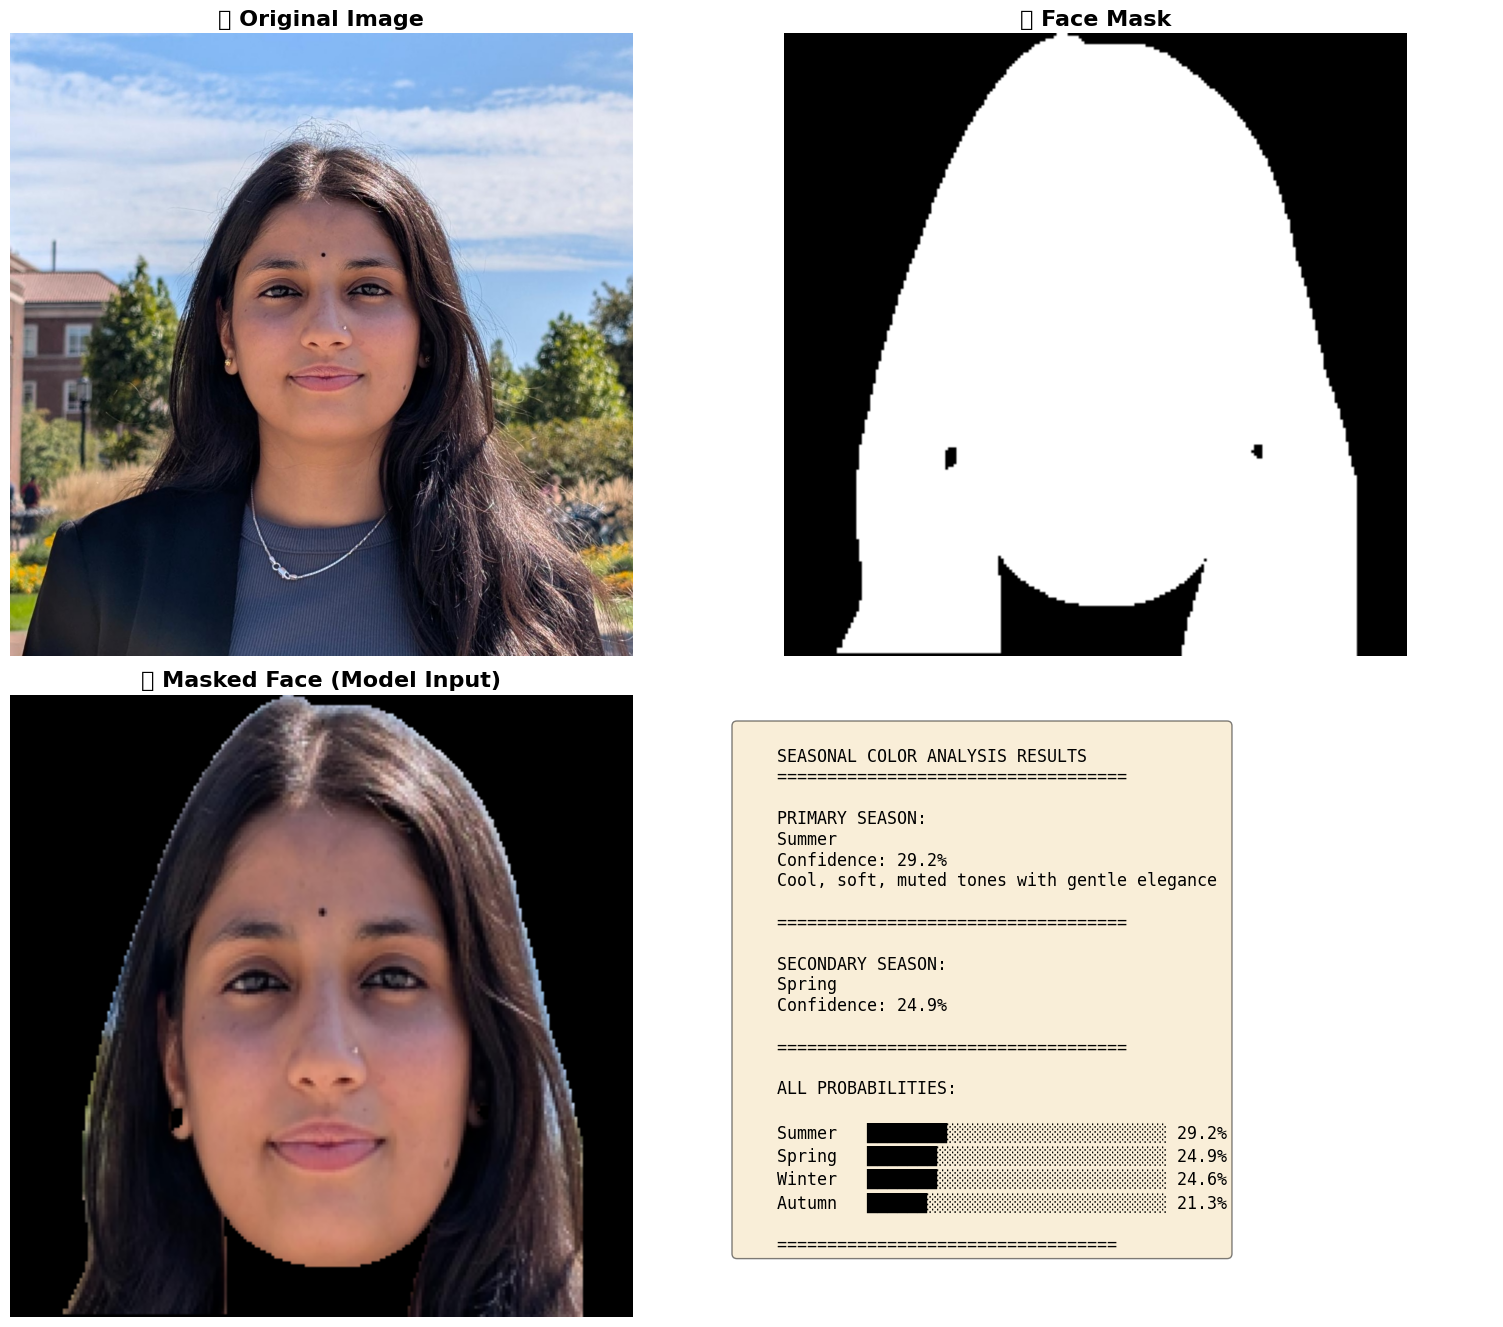

SEASONAL COLOR ANALYSIS RESULTS

 Primary Season: Summer (29.2%)
 Secondary Season: Spring (24.9%)

 All Probabilities:
   Summer  : 29.2%
   Spring  : 24.9%
   Winter  : 24.6%
   Autumn  : 21.3%


✅ Analysis complete!


In [10]:
# CELL 8: Main Testing Pipeline

print("SEASONAL COLOR ANALYSIS - TESTING")
print("="*60)
print("\n Please upload an image to analyze...")
print("   (Supported formats: JPG, PNG, JPEG)")
print("\n")

# Upload image
uploaded_images = files.upload()

if len(uploaded_images) == 0:
    print("No image uploaded! Please run this cell again.")
else:
    # Get the uploaded image
    image_name = list(uploaded_images.keys())[0]
    print(f"\n Image uploaded: {image_name}")

    # Save temporarily
    with open('temp_image.jpg', 'wb') as f:
        f.write(uploaded_images[image_name])

    print("\n" + "="*60)
    print("PROCESSING PIPELINE")
    print("="*60)

    # Step 1: Create face mask
    print("\n[1/3] Creating face mask...")
    masked_img, original_img, mask = create_face_crop_facer_style('temp_image.jpg')

    # Step 2: Run prediction
    print("\n[2/3] Running seasonal color prediction...")
    results = predict_season(masked_img)

    # Step 3: Display results
    print("\n[3/3] Displaying results...")
    display_results(original_img, masked_img, mask, results)

    print("\n✅ Analysis complete!")
    print("="*60)